In [1]:
%matplotlib notebook
#%matplotlib inline

import copy
import numpy as np
import random
import matplotlib.pyplot as plt
from _converter import SensorThings2Dict
from _plotter import plot_confusion_matrix

In [2]:
print("Loading rows...")
with open("ABU1.txt") as f:
    data = []
    bad = 0
    for line in f:
        try:
            features = SensorThings2Dict(line)
            data.append(list(features.values()))
        except Exception, e:
            bad+=1
print("Incomplete rows: {}".format(bad))
print("Loaded: {}".format(len(data)))

""" random split seed """
data = np.asarray(data)
#print(data[:,2:-1])
# numerics = data[:,2:-1]
# for n in numerics[data[:,-1]=='True']:
#     plt.plot(n);
mask = np.random.rand(len(data)) < 0.9

Loading rows...
Incomplete rows: 170
Loaded: 30768


In [20]:
train = data[mask]
test = data[~mask]
print("Train Total: {} Good: {} Faulty: {} Ratio: {}".format(len(train), len(train[train[:,-1]=='True']), len(train[train[:,-1]=='False']), float(len(train[train[:,-1]=='False']))/len(train)))
print("Test  Total: {} Good: {} Faulty: {} Ratio: {}".format(len(test), len(test[test[:,-1]=='True']), len(test[test[:,-1]=='False']), float(len(test[test[:,-1]=='False']))/len(train)))

Train Total: 27751 Good: 26130 Faulty: 1621 Ratio: 0.0584123094663
Test  Total: 3017 Good: 2853 Faulty: 164 Ratio: 0.00590969694786


In [21]:
faulty = train[train[:,-1]=='False']
not_faulty = train[train[:,-1]=='True']
# train = np.concatenate((not_faulty[:len(faulty)*5], faulty))
samples = np.random.choice(len(not_faulty), 3000, replace=False)
train = np.concatenate((not_faulty[samples], faulty))
print("Train Total: {} Good: {} Faulty: {} Ratio: {}".format(len(train), len(train[train[:,-1]=='True']), len(train[train[:,-1]=='False']), float(len(train[train[:,-1]=='False']))/len(train)))

train_data = train[:,2:-1].astype(np.float32)
test_data = test[:,2:-1].astype(np.float32)
"""
Quality_OK is mapped to Faultiness
    'False' -> 1 (Faulty)
    'True'  -> 0 (Good)
"""
train_labels = np.array(train[:,-1]=='False').astype(np.int32)
test_labels = np.array(test[:,-1]=='False').astype(np.int32)

Train Total: 4621 Good: 3000 Faulty: 1621 Ratio: 0.350789872322


In [22]:
from sklearn import metrics
from IPython.display import display, HTML
import pandas as pd

def eval_metrics(expected, predicted):
    print("------------------------- EVALUATION -------------------------")
#     print("Accuracy Score: {}".format(metrics.accuracy_score(expected, predicted)))
    print(metrics.classification_report(expected, predicted))
    print("Confusion Matrix:")
#     print(metrics.confusion_matrix(expected, predicted))
    display(pd.DataFrame(metrics.confusion_matrix(expected, predicted)))
#     print("Kappa Score: {}".format(metrics.cohen_kappa_score(expected, predicted)))
    print("Matthews Correlation Coefficient: {}".format(metrics.matthews_corrcoef(expected, predicted)))
    print("--------------------------------------------------------------")
#     plot_confusion_matrix(metrics.confusion_matrix(expected, predicted),classes=['Good','Faulty'],title='Confusion matrix',normalize=True)
#     plt.show()

<IPython.core.display.Javascript object>


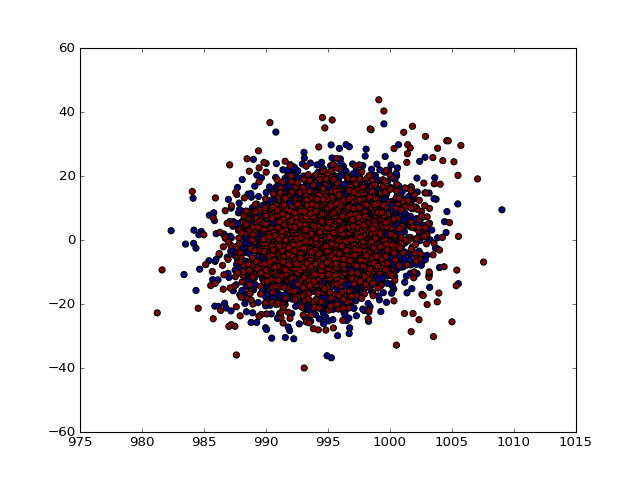

In [23]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
svd = TruncatedSVD(n_components=2, n_iter=100, random_state=1)
reduced = svd.fit_transform(train_data) 
#train_data = svd.transform(train_data)
#test_data = svd.transform(test_data)
# print(reduced)
plt.scatter(reduced[:,0],reduced[:,1], c=train_labels, s=30)

# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(reduced[:,0],reduced[:,1], reduced[:,2], c=train_labels, s=30)
# plt.show()

In [24]:
""" Classification and Regression Trees (CART) """
from sklearn.tree import DecisionTreeClassifier

# ratio = float(len(train[train[:,-1]=='False']))/len(train)
criteria = ["gini", "entropy"]
clf = DecisionTreeClassifier(criterion=criteria[0], random_state=1, max_depth=100,  class_weight={0:1.0, 1:0.05})

%time t = clf.fit(train_data, train_labels)

# print(clf.predict_proba(test_data[:,r]))
eval_metrics(train_labels, clf.predict(train_data))
eval_metrics(test_labels, clf.predict(test_data))

# from sklearn.tree import export_graphviz
# from subprocess import call
# export_graphviz(clf, out_file='treeT.dot', class_names=True) 
# call(["dot","-Tpng","treeT.dot","-o","treeT.png"])

Wall time: 793 ms
------------------------- EVALUATION -------------------------
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      3000
          1       1.00      0.98      0.99      1621

avg / total       0.99      0.99      0.99      4621

Confusion Matrix:


,0,1
0,3000,0
1,26,1595


Matthews Correlation Coefficient: 0.987677139415
--------------------------------------------------------------
------------------------- EVALUATION -------------------------
             precision    recall  f1-score   support

          0       1.00      0.99      0.99      2853
          1       0.80      0.98      0.88       164

avg / total       0.99      0.99      0.99      3017

Confusion Matrix:


,0,1
0,2812,41
1,4,160


Matthews Correlation Coefficient: 0.873956470297
--------------------------------------------------------------


In [ ]:
# """ ExtraTreeClassifier """
# from sklearn.tree import ExtraTreeClassifier

# # ratio = float(len(train[train[:,-1]=='False']))/len(train)
# clf = ExtraTreeClassifier(max_depth=70)
# %time t = clf.fit(train_data, train_labels)

# eval_metrics(train_labels, clf.predict(train_data))
# eval_metrics(test_labels, clf.predict(test_data))

In [25]:
""" Random Forest """
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100,  class_weight={0:1.0, 1:0.05}, max_depth=90, n_jobs=4)

%time clf = clf.fit(train_data, train_labels)
eval_metrics(train_labels, clf.predict(train_data))
eval_metrics(test_labels, clf.predict(test_data))

Wall time: 3.1 s
------------------------- EVALUATION -------------------------
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      3000
          1       1.00      0.98      0.99      1621

avg / total       0.99      0.99      0.99      4621

Confusion Matrix:


,0,1
0,2999,1
1,34,1587


Matthews Correlation Coefficient: 0.983414711848
--------------------------------------------------------------
------------------------- EVALUATION -------------------------
             precision    recall  f1-score   support

          0       1.00      0.99      0.99      2853
          1       0.85      0.98      0.91       164

avg / total       0.99      0.99      0.99      3017

Confusion Matrix:


,0,1
0,2824,29
1,3,161


Matthews Correlation Coefficient: 0.906765407233
--------------------------------------------------------------


In [ ]:
import random
from copy import deepcopy
def randomPair(predicted_label):
    index = random.sample(np.where(train_labels==abs(1-predicted_label))[0],1)
    return deepcopy(train_data[index][0]), deepcopy(train_labels[index][0])

for i,t in enumerate(test_data):
    prediction = clf.predict([t])[0]
    pair_data, pair_label = randomPair(prediction)
#     print(test_data[i])
#     print(pair_data)
    clf = clf.fit([test_data[i],pair_data], [prediction,pair_label])

eval_metrics(train_labels, clf.predict(train_data))
eval_metrics(test_labels, clf.predict(test_data))

In [ ]:
""" Bagging Classifier """ 
from sklearn.ensemble import BaggingClassifier
from sklearn import metrics

clf = BaggingClassifier(n_estimators=50, random_state=1)
%time clf = clf.fit(train_data, train_labels)

eval_metrics(train_labels, clf.predict(train_data))
eval_metrics(test_labels, clf.predict(test_data))

In [7]:
from endpoints import Controller


ImportError: No module named endpoints